In [173]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [174]:
model = AutoEncoder(in_channels=1)
model.load_state_dict(torch.load('trained_models/auto_encoder.pt'))

<All keys matched successfully>

In [175]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
(28, 28, 1)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6


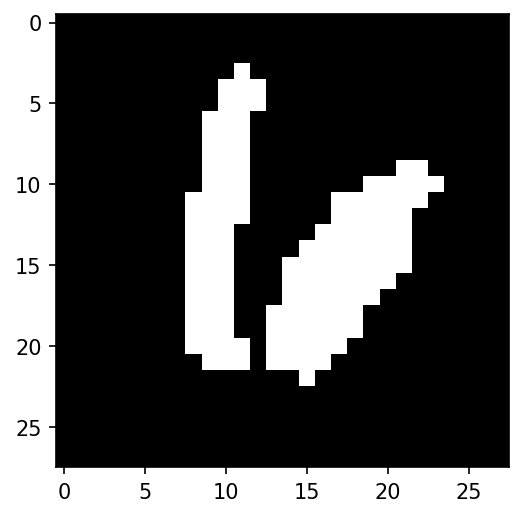

In [176]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

rand = np.random.randint(0, x_train.shape[0])
img = x_train[rand]
label = y_train[rand]
print(img.shape)

print(label)
print(label.argmax())
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img, cmap="gray")

(1, 28, 28)


(array([65., 97., 81., 90., 77., 73., 72., 83., 66., 80.]),
 array([3.59453232e-04, 1.00265495e-01, 2.00171536e-01, 3.00077578e-01,
        3.99983619e-01, 4.99889660e-01, 5.99795702e-01, 6.99701743e-01,
        7.99607785e-01, 8.99513826e-01, 9.99419868e-01]),
 <BarContainer object of 10 artists>)

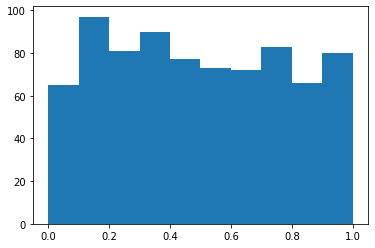

In [177]:
z = np.random.uniform(0, 1, size=(1, 28, 28))
print(z.shape)
plt.hist(z.flatten())

In [178]:
img = torch.from_numpy(img.astype(np.float32))
img = img.permute(2,0,1)

In [179]:
img.shape

torch.Size([1, 28, 28])

In [180]:
z = torch.from_numpy(z.astype(np.float32))

model.eval()
with torch.no_grad():
    generated_image = model(img)
    generated_image = torch.sigmoid(generated_image)

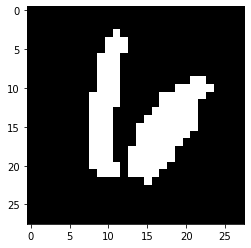

In [181]:
plt.imshow(generated_image.permute(1, 2, 0), cmap="gray")